# Introduction to phylogenetic comparative methods in R
Goettingen 2023  
Andrew Hipp, ahipp@mortonarb.org  
Tutorial 03b: Stretching the tree and manipulating   
Use [static view in nbviewer](https://nbviewer.org/github/andrew-hipp/workshops/blob/master/2023-goettingen/Wk3-EvolutionaryProcess/03b.treeStretching.ipynb) if you are not working directly in Jupyter notebooks.

# Session 3b: Evaluating alternative continuous trait evolution models
In this tutorial, you'll:
1. practice testing for shifts in the rate of evolution on a tree, using an approach adapated from O'Meara's (2006) method
1. Use Pagel's $\lambda$ to test for phylogenetic signal, then visualize the likelihood of your model from $\lambda$ of 0 to 1.

# 1. Comparing a one-rate model with a two-rate model

Let's start with the example of a very simple censored two-rate model as we discussed in lecture. First let's generate a tree:

In [103]:
library(geiger)
library(phytools)
tr <- sim.bdtree(n = 20)

Now, let's simulate a trait evolving on that tree, with a single shift in the rate of evolution. We'll do so by first transforming the tree so that one clade is stretched out; we'll then simulate data according to a Brownian motion process on that transformed tree:

In [104]:
tr2 <- ex.ratesimulator(tr, min = 5)
dat2 <- sim.char(tr2,1,1)[,,1]

the stretched (high-rate) clade:



 [1] "s6"  "s7"  "s8"  "s9"  "s10" "s11" "s12" "s13" "s14" "s15"


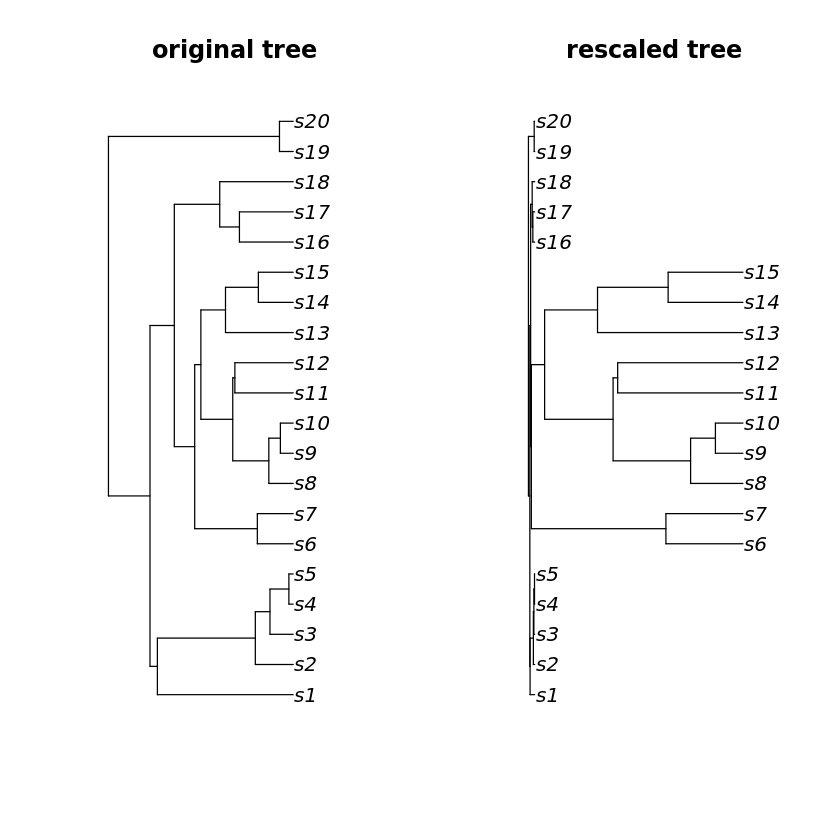

In [105]:
layout(matrix(1:2, 1))
plot(tr, main = 'original tree')
plot(tr2, main = 'rescaled tree')
message('the stretched (high-rate) clade:')
fastCladeTips <- 
  names(which(round(diag(vcv(tr2)), 3) == max(round(diag(vcv(tr2)), 3))))
print(fastCladeTips)

Consider what these trees imply. The tree on the left side is our original tree, scaled in units of time. The tree on the right side simulates the effects of a single increase in ch. We can use the `geiger` package to estimate the Brownian motion model parameters on these for the single-rate model:

In [106]:
models <- list(
    fittedToRescaledTree = fitContinuous(tr2, dat2),
    fittedToOriginalTree = fitContinuous(tr,dat2)
)
models.mat <- cbind(fittedToRescaledTree = models$fittedToRescaledTree$opt,
                    fittedToOriginalTree = models$fittedToOriginalTree$opt)
models.mat <- rbind(models.mat, aic.w = aic.w(as.numeric(models.mat['aic',]))) # here, using phytools function
print(models.mat)

       fittedToRescaledTree fittedToOriginalTree
sigsq  0.8875271            17.6172             
z0     2.020325             2.914906            
lnL    -43.38346            -53.03385           
method "Brent"              "Brent"             
k      2                    2                   
aic    90.76693             110.0677            
aicc   91.47281             110.7736            
aic.w  0.9999356            6.439658e-05        


Not surprisingly, the rescaled tree explains the data better. It confers a higher likelihood on the trait data, because the variance structure of the data was created under the second tree.

But imagine that we inferred tree 1 from our data and had some hypotheses about what changes we had found. If we want to test these following the O'Meara method, we'll first we need the pieces of the model. These are the GLS estimators that O'Meara et al. (2006) use to estimate the rate of trait evolution. We'll write a separate functions for each of the following:
* The phylogenetic mean (or ancestral state at the root)
* Sigma-squared (the rate)
* The log-likelihood

In [107]:
library(ape)

rootState <- function(tr, X) {
  ## the maximum likelihood estimate of root state based on O'Meara, p. 925
  vcvMat <- vcv(tr)
  one <- matrix(1, length(X), 1) # a matrix of 1s, as tall as the length of X
  B0 <- as.numeric(solve(t(one) %*% solve(vcvMat) %*% one) %*% (t(one) %*% solve(vcvMat) %*% X))
  return(B0)
  }

sigmaSq <- function(tr, X) {
  ## following O'Meara 2006, eq. 2
  vcvMat <- vcv(tr)
  N <- length(X)
  E.X <- matrix(rootState(tr, X), length(X), 1) # expected value of X is just the rootstate of X
  sigmaSq <- as.numeric((t(X - E.X) %*% solve(vcvMat) %*% (X - E.X)) / N)
  out <- list(V = vcvMat * sigmaSq, sigmaSq = sigmaSq, X = X, E.X. = E.X, N = N)
  class(out) <- "phylogSigmaSq"
  return(out)
  }

logLik.phylogSigmaSq <- function(object, ...) {
  # following O'Meara 2006, eq. 3
  # takes output from sigmaSq
  numer <- exp(-0.5 * t(object$X - object$E.X) %*% solve(object$V) %*% (object$X - object$E.X))
  denom <- sqrt((2*pi)^object$N * det(object$V))
  out <- log(numer / denom)
  attr(out, "nobs") <- object$N
  attr(out, "df") <- 2
  class(out) <- "logLik"
  return(out)
  }

This is a little clunky, but it should do. Let's try it out with our data and make sure everything works:

In [108]:
d.a <- rootState(tr, dat2)
d.s <- sigmaSq(tr, dat2)
d.L <- logLik(d.s)
message('our function results:')
print(d.a)
print(d.L)
print(d.s$sigmaSq)

message('for comparison, results from geiger, fitContinuous:')
fitContinuous(tr, dat2) |> print()


our function results:



[1] 2.914906
'log Lik.' -53.03385 (df=2)
[1] 17.6172


for comparison, results from geiger, fitContinuous:



GEIGER-fitted comparative model of continuous data
 fitted ‘BM’ model parameters:
	sigsq = 17.617196
	z0 = 2.914906

 model summary:
	log-likelihood = -53.033849
	AIC = 110.067697
	AICc = 110.773579
	free parameters = 2

Convergence diagnostics:
	optimization iterations = 100
	failed iterations = 0
	number of iterations with same best fit = 100
	frequency of best fit = 1.000

 object summary:
	'lik' -- likelihood function
	'bnd' -- bounds for likelihood search
	'res' -- optimization iteration summary
	'opt' -- maximum likelihood parameter estimates


Then, we'll code a function to perform the censored test of O'Meara et al. Our function will take a tree, some definition of how the tree should be split up into groups, and a vector of data. These are the arguments of your function. The value of oour function (what it returns) should include the log-likelihood of the model, the root state, and sigma-squared for each subtree.

There are a lot of ways to approach this problem, but I'll walk you through how I might do it. First, we need a function to split a tree into subtrees. Let's call this function `censor`.

In [109]:
censor <- function(tr, taxa = 2) {
  ## tr is a tree of class "phylo"
  ## taxa is a list of taxa defining subtrees, or a single number for the number of subtrees you'd like to define somewhat interactively
  if(class(taxa) == "numeric" && length(taxa) == 1) {
    taxa <- vector("list", taxa)
    for(i in seq(length(taxa))) taxa[[i]] <- select.list(tr$tip.label, multiple = TRUE, title = "Select taxa comprising one subtree")
    }
  if(!identical(sort(unlist(taxa)), sort(tr$tip.label))) warning("Taxa do not represent non-overlapping sets of taxa on the tree")
  treeList <- vector("list",length(taxa))
  for(i in seq(length(taxa))) {
    tipsToDrop <- tr$tip.label[-which(tr$tip.label %in% taxa[[i]])]
    treeList[[i]] <- drop.tip(tr, tipsToDrop)
    }
  return(treeList)
  }

Let's try it out to see how it works on our rescaled tree:

[[1]]

Phylogenetic tree with 10 tips and 9 internal nodes.

Tip labels:
  s6, s7, s8, s9, s10, s11, ...

Rooted; includes branch lengths.

[[2]]

Phylogenetic tree with 10 tips and 9 internal nodes.

Tip labels:
  s1, s2, s3, s4, s5, s16, ...

Rooted; includes branch lengths.


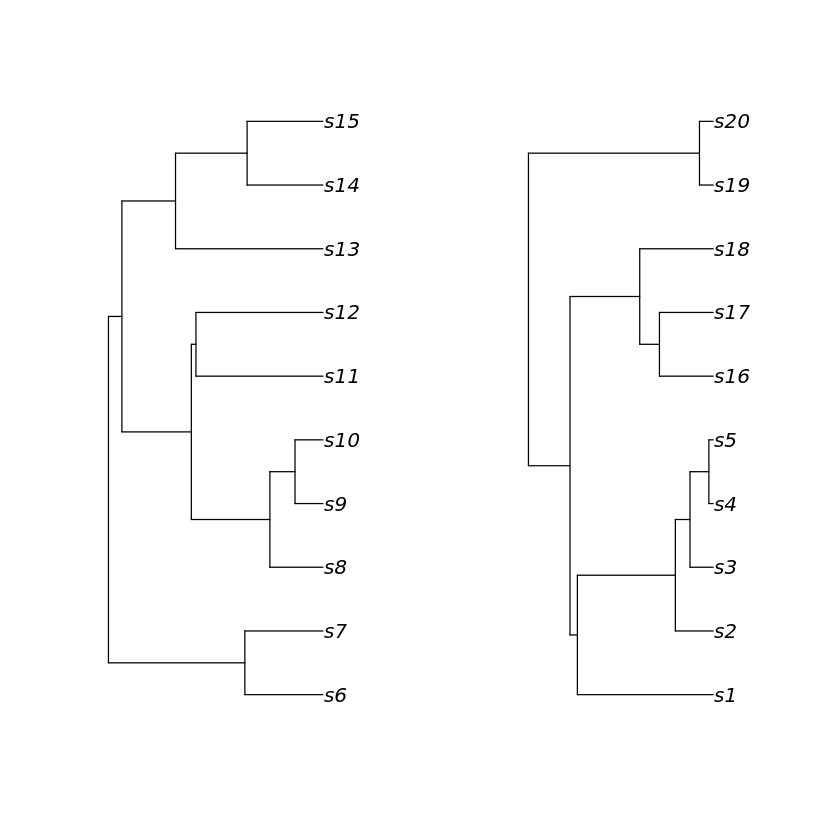

In [110]:
# then, split that one out:
treesOut <- censor(tr, taxa = list(fastCladeTips, setdiff(tr$tip.label, fastCladeTips)))
treesOut
layout(matrix(1:2, 1))
plot(treesOut[[1]])
plot(treesOut[[2]])

What we've done is to cleave out the fast-evolving clade as a separate subtree.

Now, we need a function to actually test the models.

In [141]:
testModels <- function(tr, X, multiRateModels = 1, modelList = NULL, ...) {
  ## tests a single-rate model against a single multiple-rate models
    # -- should be generalized to compare the single-rate model against as many multiple-rate models as you like
  ## currently only the censored option is implemented
  ## Arguments:
  ##  tr = tree of class "phylo"
  ##  X = vector of trait values
  ##  multiRateModels = number of multiple-rate models to test
  ##  modelList = list of list of trees; if NULL, trees are created interactively using censor function
   
  ## 1. Check the data out a bit to catch obvious problems
  vcvMat <- vcv(tr)
  if(length(X) != dim(vcvMat)[1]) stop("This function currently only takes vectors of trait values equal in length to the number of taxa in the tree")
  if(identical(names(X), NULL)) {
    warning("X has no labels; assumed to be ordered the same as VCV matrix")
    names(X) <- dimnames(vcvMat)[[1]]
    }
  else {
    if(!all(names(X) %in% dimnames(vcvMat)[[1]])) warning("X labels not identical to tip labels; traits assumed to be ordered the same as VCV matrix")
    vcvMat <- vcvMat[names(X), names(X)]
    }
  
  ## 2. Set up the models
  treeSets <- vector("list", 1 + multiRateModels)
  treeSets[[1]] <- list(tr) ## necessary to make this a list of length=1 so that the nested loop below works
  maxTrees <- 1
  for(i in 2:(1 + multiRateModels)) {
    if(class(modelList) == 'list') {
      taxa <- length(modelList[[i-1]])
      treeSets[[i]] <- modelList[[i-1]] # use trees if provided, or ...
      } ## close if
    else {
      taxa <- as.numeric(select.list(c('2','3','4','5','6','7','8','9','10'), preselect = "2", title = "Select the number of subtrees you would like"))
      treeSets[[i]] <- censor(tr, taxa) # ... do interactive tree creation if no trees are handed in via modelList
      } ## close else
    maxTrees <- max(taxa, maxTrees)
    } ## close i
  
  ## 3. Set up matrix to capture output
  paramsBase <- c("sigma.sq", "root")
  params <- paste(sort(rep(paramsBase, maxTrees)), rep(1:maxTrees,length(paramsBase)), sep = ".")
  results <- matrix(NA, nrow = length(treeSets), ncol = 2 + length(paramsBase)*maxTrees, dimnames = list(1:length(treeSets), c('lnL', 'df', params)))
  for(i in 1:length(treeSets)) {
    message(paste('running treeSet', i))
    results[i, c('lnL', 'df')] <- c(0,0)
    for(j in 1:length(treeSets[[i]])) {
      if(class(treeSets[[i]]) != 'phylo') tr.temp <- treeSets[[i]][[j]]
      sigma.sq.temp <- sigmaSq(tr.temp, X[tr.temp$tip.label])
      lnL.temp <- logLik(sigma.sq.temp)
      results[i, c('lnL', 'df')] <- results[i, c('lnL', 'df')] + c(lnL.temp, attr(lnL.temp, 'df'))
      results[i, paste(paramsBase, j, sep = ".")] <- c(sigma.sq.temp$sigmaSq,                         ## sigma.sq
                                                       rootState(tr.temp, X[tr.temp$tip.label])  ## root
                                                       )                                              ## and close that concatenation
    } ## close j
  } ## close i
  results <- list(treeSets = treeSets, modelSummary = results)
  return(results)
  }

Let's try it out on our dataset from above. Let's imagine that we hypothesize three rate-shift scenarios: a shift at clade (s1, s2, s3); a shift at the simultated rate-shift clade; and a shift at both. We'll compare all of these against the single-rate tree. First, let's set up our models:

In [123]:
modelset = list(
  c1 = censor(tr, taxa = list(
      fastCladeTips, 
      setdiff(tr$tip.label, fastCladeTips))),
  c2 = censor(tr, taxa = list(
      c('s1', 's2', 's3'), 
      setdiff(tr$tip.label, c('s1', 's2', 's3')))),
  c3 = censor(tr, taxa = list(
      c('s1', 's2', 's3'),
      fastCladeTips, 
      setdiff(tr$tip.label, c(fastCladeTips, 's1', 's2', 's3'))))
)

In [162]:
output <- testModels(tr, dat2, multiRateModels = 3, modelList =modelset)
print(output$modelSummary)

running treeSet 1

running treeSet 2

running treeSet 3

running treeSet 4



        lnL df   root.1   root.2   root.3 sigma.sq.1 sigma.sq.2 sigma.sq.3
1 -53.03385  2 2.914906       NA       NA 17.6171957         NA         NA
2 -41.93028  4 5.984394 1.970260       NA 32.2184634   1.174022         NA
3 -50.51278  4 2.738618 2.923877       NA  0.9417767  20.562152         NA
4 -41.86245  6 2.738618 5.984394 1.663861  0.9417767  32.218463   1.083276


From this, what would you say is the best-fit model? Take into account both the likelihood and the model complexity. And we'd better add aic in there! Let's make a little aic function:

In [163]:
aic = function(L, df) {
  out <- -2 * L + 2 * df
  return(out)
    }

        aic        aic_w       lnL df   root.1   root.2   root.3 sigma.sq.1
1 110.06770 9.716599e-05 -53.03385  2 2.914906       NA       NA 17.6171957
2  91.86056 8.732624e-01 -41.93028  4 5.984394 1.970260       NA 32.2184634
3 109.02556 1.636107e-04 -50.51278  4 2.738618 2.923877       NA  0.9417767
4  95.72491 1.264769e-01 -41.86245  6 2.738618 5.984394 1.663861  0.9417767
  sigma.sq.2 sigma.sq.3
1         NA         NA
2   1.174022         NA
3  20.562152         NA
4  32.218463   1.083276


... and add AIC and AIC weights to this table:

In [164]:
output$modelSummary <- cbind(
    aic = aic(output$modelSummary[, 1], output$modelSummary[, 2]),
    aic_w = aic.w(aic(output$modelSummary[, 1], output$modelSummary[, 2])),
    output$modelSummary
    )
output$modelSummary

,aic,aic_w,aic,aic_w,lnL,df,root.1,root.2,root.3,sigma.sq.1,sigma.sq.2,sigma.sq.3
1,-220.1352,7.392749e-01,110.06770,9.716599e-05,-53.03385,2,2.914906,NA,NA,17.6171957,NA,NA
2,-181.9746,3.822383e-09,91.86056,8.732624e-01,-41.93028,4,5.984394,1.970260,NA,32.2184634,1.174022,NA
3,-218.0508,2.607248e-01,109.02556,1.636107e-04,-50.51278,4,2.738618,2.923877,NA,0.9417767,20.562152,NA
4,-191.1969,3.845266e-07,95.72491,1.264769e-01,-41.86245,6,2.738618,5.984394,1.663861,0.9417767,32.218463,1.083276


In [100]:
load('../phyloLive//tutorial.01/data/phylo.session01b.Rdata')
ls()
dim(dat.bio.means)
tr
fitContinuous(tr, dat.bio.means[, 'bio4']) |> print()

[1] "babyTree"             "censor"               "d.a"                 
 [4] "d.L"                  "d.s"                  "dat.bio"             
 [7] "dat.bio.bySp"         "dat.bio.means"        "dat.bio.sem"         
[10] "dat.geog"             "dat.geog.cat"         "dat.lf"              
[13] "dat.pca"              "dat.sect.colors"      "dat.sect.colVect"    
[16] "dat.sect.desc"        "dat.sect.edges"       "dat.sect.mrca"       
[19] "dat.sect.vector"      "dat.sections"         "dat2"                
[22] "fastCladeTips"        "i"                    "lL"                  
[25] "lL.phylogSigmaSq"     "logLik.phylogSigmaSq" "models"              
[28] "models.mat"           "numCols"              "p"                   
[31] "p1"                   "p2"                   "path"                
[34] "pc.dat"               "pp"                   "rootState"           
[37] "sigmaSq"              "spp.intersect"        "temp.na"             
[40] "temp.sd"              "tips"                 "tr"                  
[43] "tr2"                  "treesOut"             "trType"

[1] 133  21


Phylogenetic tree with 133 tips and 132 internal nodes.

Tip labels:
  Quercus_turbinella, Quercus_ajoensis, Quercus_toumeyi, Quercus_grisea, Quercus_oblongifolia, Quercus_engelmannii, ...

Rooted; includes branch lengths.

GEIGER-fitted comparative model of continuous data
 fitted ‘BM’ model parameters:
	sigsq = 170028.695215
	z0 = 5341.755163

 model summary:
	log-likelihood = -1172.711316
	AIC = 2349.422632
	AICc = 2349.514939
	free parameters = 2

Convergence diagnostics:
	optimization iterations = 100
	failed iterations = 0
	number of iterations with same best fit = 100
	frequency of best fit = 1.000

 object summary:
	'lik' -- likelihood function
	'bnd' -- bounds for likelihood search
	'res' -- optimization iteration summary
	'opt' -- maximum likelihood parameter estimates


# 2. Using two existing tools to do the same thing


In [ ]:
rjRun <- rjmcmc.bm(multi2di(tr), dat2[,,1], filebase = 'jumpTrial') # running with default 20,000 generations

In [ ]:
library(geiger)
dirBase = 'jump-relaxedBM.jumpTrial'
ps = load.rjmcmc(dirBase)
defpar <- par(no.readonly=TRUE)

hist <- tr2$hist
plot(x=ps, par="jumps", burnin=0.25, legend=FALSE, show.tip=FALSE, type="fan", edge.width=2)
mm=match(tr$edge[,2],hist$descendant)
hist=hist[mm,]
edgelabels.auteur(text=NULL, pch=21, cex=hist$cex, bg=NA, col=ifelse(hist$cex>0, 1, NA), lty=2)
title("red (estimated); black (true jump size)", line=-5)
par(defpar)

# 3. Phylogenetic signal
2. Make a tree. Generate data using the ```sim.char``` function on the original tree and the tree rescaled to ```lambda = 0.5```. Plot the log-likelihood of your data from lambda = 0 to lambda = 0.5. Using a lnL level of 2 as your significance level, visualize the confidence you should have in your point estimate. Try the same exercise with several trees of 20 taxa and several of 50 taxa. How does your power to detect a lambda < 1 vary with sample size?  

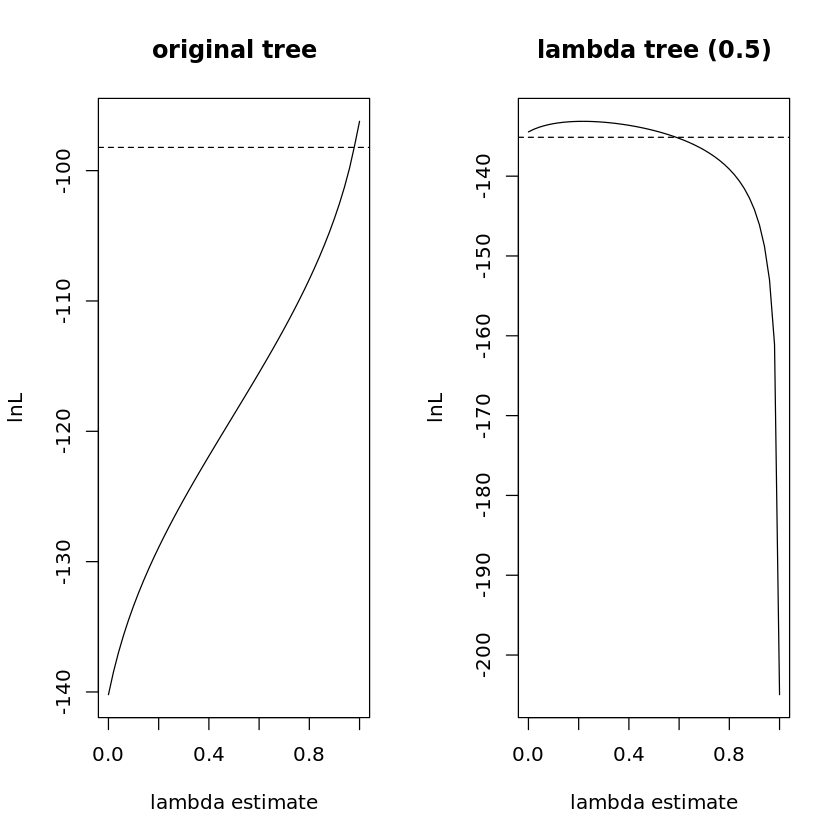

In [167]:
library(geiger)
library(phytools)

tr3 <- pbtree(n = 70)
x.raw <- sim.char(tr3, 1)[,,]
x.lambda.5 <- sim.char(rescale(tr3, 'lambda', 0.5), 1)[,,]
par(mfrow=c(1,2))
x.vals <- seq(from = 0, to = 1, by = 0.02)
y.raw <- sapply(x.vals, function(w) {
    tr.temp <- rescale(tr3, 'lambda', w)
    logLik.phylogSigmaSq(sigmaSq(tr.temp, x.raw))
    }
    )
y.lambda <- sapply(x.vals, function(w) {
    tr.temp <- rescale(tr3, 'lambda', w)
    logLik.phylogSigmaSq(sigmaSq(tr.temp, x.lambda.5))
    }
    )

plot(x.vals, y.raw, main = 'original tree', xlab = 'lambda estimate', ylab = 'lnL', type = 'l')
abline(h = max(y.raw)-2, lty = 'dashed')
plot(x.vals, y.lambda, main = 'lambda tree (0.5)', xlab = 'lambda estimate', ylab = 'lnL', type = 'l')
abline(h = max(y.lambda)-2, lty = 'dashed')